### 필요한 라이브러리 Import

In [92]:
import os

from konlpy.tag import Okt
from gensim.models import Word2Vec

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

### 데이터 확인

In [7]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

### Konlp를 활용한 명사 추출

In [8]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

* 토크나이저의 내용 일부와 길이를 확인해 보겠습니다.

In [10]:
print(tokenized[:3])
print(len(tokenized))

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'], ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'], ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를']]
71156


* 임베딩 벡터를 생성하겠습니다.

In [11]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

* 영화와 비슷한 단어를 출력해보겠습니다.

In [12]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8860414028167725),
 ('다큐멘터리', 0.8521943688392639),
 ('드라마', 0.8244699835777283),
 ('영화로', 0.8073450922966003),
 ('디지털화', 0.7926079034805298),
 ('형식', 0.7827721238136292),
 ('코미디', 0.7822396159172058),
 ('주제', 0.7746337652206421),
 ('스토리', 0.771571934223175),
 ('감동', 0.7700704336166382)]

* 단어들이 영화랑 많이 근접하다고 생각합니다. 

### WEAT Target

* 시놉스의 명사를 추출하는 함수를 만듭니다.

In [19]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, "r") as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [20]:
art = read_token('synopsis_art.txt')
gen = read_token('synopsis_gen.txt')

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [21]:
print(len(art))
print(len(gen))

620208
3014815


* 예술영화와 일반영화의 단어수가 많아 대표 단어를 선정해보겠습니다.

### TF-IDF 만들기

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


* 추출한 명사를 이용해 TF-IDF를 만들었습니다. 출력해 보겠습니다.

In [74]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print('(',vectorizer.get_feature_names()[w1[i][0]].center(3), round(w1[i][1], 3), end=' ) ')
    if (i+1) % 8 == 0: print();
print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print('(',vectorizer.get_feature_names()[w2[i][0]].center(3),round(w2[i][1], 3), end=' )     ')
    if (i+1) % 6 == 0: print();

예술영화를 대표하는 단어들:
(  그녀 0.304 ) (  자신 0.295 ) (  시작 0.291 ) (  위해 0.261 ) (  사랑 0.255 ) (  사람 0.234 ) (  영화 0.156 ) (  친구 0.151 ) 
(  남자 0.134 ) (  가족 0.112 ) ( 이야기 0.11 ) (  마을 0.105 ) (  사건 0.099 ) (  마음 0.098 ) (  세상 0.098 ) ( 아버지 0.095 ) 
(  아이 0.094 ) (  엄마 0.093 ) (  모든 0.092 ) (  여자 0.091 ) (  대한 0.088 ) (  서로 0.086 ) (  과연 0.086 ) (  다시 0.083 ) 
(  시간 0.083 ) (  아들 0.08 ) (  소녀 0.077 ) (  아내 0.073 ) (  다른 0.071 ) (  사이 0.069 ) ( 영화제 0.069 ) (  세계 0.069 ) 
(  사실 0.068 ) (  하나 0.066 ) (  점점 0.063 ) (  남편 0.062 ) (  감독 0.061 ) (  여행 0.061 ) (  인생 0.06 ) (  발견 0.059 ) 
(  모두 0.059 ) (  순간 0.059 ) (  우리 0.058 ) (  가장 0.057 ) ( 마지막 0.054 ) (  생활 0.054 ) (  아빠 0.054 ) (  모습 0.053 ) 
(  통해 0.053 ) (  죽음 0.052 ) (  기억 0.052 ) (  비밀 0.052 ) (  학교 0.052 ) (  음악 0.051 ) (  한편 0.05 ) (  소년 0.048 ) 
(  생각 0.047 ) (  도시 0.047 ) (  명의 0.047 ) (  사고 0.046 ) (  결혼 0.046 ) (  전쟁 0.046 ) (  때문 0.046 ) (  위기 0.046 ) 
(  이제 0.044 ) (  최고 0.044 ) (  이자 0.044 ) (  과거 0.043 ) (  일상 0.043 ) (  경찰 0.042 ) 

* 잘 나옵니다. 이제 모든 영화장르에 적용시켜보겠습니다.

In [76]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [78]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [79]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [86]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]].center(3), round(w[i][j][1], 3), end=', ')
            if (j+1) % 5 == 0: print();
        j += 1
    attributes.append(attr)
    print()

SF:  위해 0.261,  자신 0.258,  지구 0.243,  시작 0.227,  사람 0.193, 
 인류 0.189,  인간 0.148,  미래 0.13,  우주 0.125,  그녀 0.115, 
 로봇 0.114,  세계 0.112,  모든 0.107,  박사 0.102, 우주선 0.093, 

가족:  엄마 0.247,  아빠 0.226,  가족 0.203, 영화제 0.2,  자신 0.194, 
 위해 0.175,  친구 0.153, 아주르 0.151, 아버지 0.15,  시작 0.146, 
 그녀 0.143,  아들 0.124,  마을 0.121,  국제 0.121,  낙타 0.117, 

공연: 오페라 0.267,  사랑 0.265, 토스카 0.214,  실황 0.205,  올레 0.165, 
 자신 0.163,  카바 0.147,  그녀 0.138,  공연 0.125, 오텔로 0.122, 
리골레토 0.121,  백작 0.112,  프레 0.111, 베르디 0.11,  위해 0.11, 

공포(호러):  시작 0.258,  위해 0.242,  사람 0.24,  자신 0.232,  친구 0.223, 
 그녀 0.222,  사건 0.187,  공포 0.165,  발견 0.148,  죽음 0.132, 
 마을 0.117,  가족 0.099,  악령 0.098,  남자 0.096,  좀비 0.093, 

기타: 영화제 0.51,  국제 0.395,  서울 0.356,  단편 0.309,  영화 0.149, 
 자신 0.146,  사람 0.136, 이야기 0.127,  그녀 0.119,  남자 0.102, 
 위해 0.098,  시작 0.086,  사랑 0.085, 뉴미디어 0.082, 페스티벌 0.078, 

다큐멘터리: 영화제 0.335,  영화 0.277,  다큐 0.232,  국제 0.228, 다큐멘터리 0.218, 
 사람 0.198, 이야기 0.173,  대한 0.158,  자신 0.149,  감독 0.147, 
 위해 0.139,  서울 

* 예제에서는 2가지만 사용해서 중복값을 사용했지만 이번엔 너무 많다고 생각되서 중복단어를 제거해야된다고 생각합니다.
* 여러 시도를 해보았지만 제가 아직 코딩능력이 부족하여 중복단어 제거를 잘 못하겠습니다.

### 시각화

In [87]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [91]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [88]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [96]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
    print("\n")

SF 가족 -0.49046078
SF 공연 -0.3736973
SF 공포(호러) -0.687812
SF 기타 0.35157448
SF 다큐멘터리 0.5710528
SF 드라마 -0.3421075
SF 멜로로맨스 -0.7986501
SF 뮤지컬 0.33472982
SF 미스터리 -0.70270187
SF 범죄 -0.22962387
SF 사극 -0.86921936
SF 서부극(웨스턴) -0.3797668
SF 성인물(에로) -0.5626407
SF 스릴러 -0.5341475
SF 애니메이션 0.37486428
SF 액션 -0.4625211
SF 어드벤처 -0.74280214
SF 전쟁 0.20984289
SF 코미디 -0.40632522
SF 판타지 -0.15373698


가족 공연 0.15122783
가족 공포(호러) -0.16615158
가족 기타 0.75894356
가족 다큐멘터리 0.82547563
가족 드라마 0.23890579
가족 멜로로맨스 -0.6285136
가족 뮤지컬 0.6959566
가족 미스터리 -0.31610855
가족 범죄 0.20763639
가족 사극 -0.11368896
가족 서부극(웨스턴) 0.44675165
가족 성인물(에로) -0.31483144
가족 스릴러 -0.15028034
가족 애니메이션 0.8750114
가족 액션 0.10781645
가족 어드벤처 -0.007722902
가족 전쟁 0.63244146
가족 코미디 0.23745912
가족 판타지 0.4311352


공연 공포(호러) -0.22373447
공연 기타 0.95890933
공연 다큐멘터리 0.9361406
공연 드라마 0.089939386
공연 멜로로맨스 -0.6825093
공연 뮤지컬 0.8988938
공연 미스터리 -0.33835456
공연 범죄 0.09527007
공연 사극 -0.34393078
공연 서부극(웨스턴) 0.11382905
공연 성인물(에로) -0.4508197
공연 스릴러 -0.20328377
공연 애니메이션 0.9499962
공연 액션 

<AxesSubplot:>

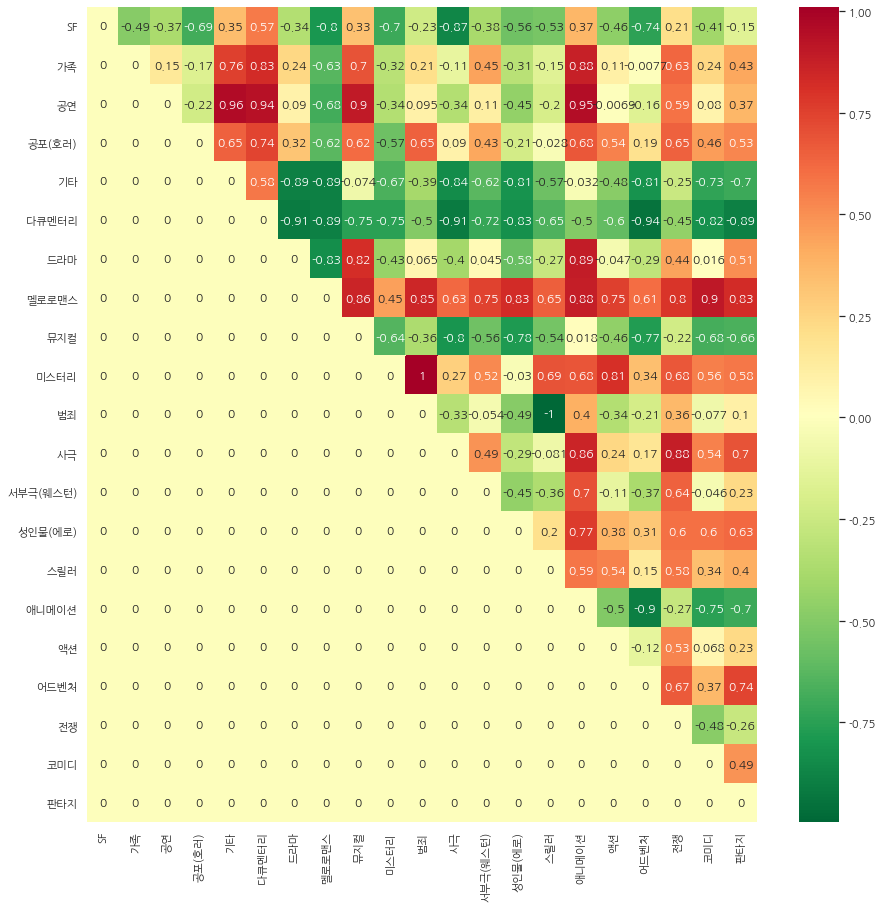

In [94]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.figure(figsize = (15, 15))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

### 회고
* 이번 프로젝트에서 가장 기억에 남는것은 중복단어의 처리였다. <br/> 단순하게 같은단어만 제거하면 TF-IDF 값이 높은값이 제거될수도 있어 높은값은 살리면서 낮은 중복단어들을 제거하고 싶었는데, 반복문을 여러번 사용하니 코드가 꼬여서 조금 더 생각해 봐야할것 같습니다.
* 느낀점은 앞으로 임베딩을 할때, 편향성을 생각하면서 임베딩을 해보고 결과값이 어떤 차이를 보일지 다른 프로젝트를 해보고싶습니다.